In [1]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import itertools

# Exercise 1 - REINFORCE

The goal of this exercise is to implement the simplest policy gradient algorith, REINFORCE, and then augment it with a baseline coming from an approximation of the value function. We will use this algorithm on the inverted pendulum model. The class below defines the pendulum model and some helper function to simulate it.

In [2]:
class Pendulum:
    """
    This class describes an inverted pendulum and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class
        """
        #gravity constant
        self.g=9.81
        
        # number of dimensions (angle and angular velocity)
        self.num_states = 2
        
        # the available control inputs
        self.controls = np.array([-5., 0., 5.])
        self.nb_controls = len(self.controls)

        # the maximum velocity
        self.vmax = 6.
        # the range of allowable states
        self.state_range = np.array([[0, 2*np.pi],[-self.vmax, self.vmax]])

        #simulation step
        self.delta_t = 0.1
        # internal integration step
        self._internaldt = 0.01
        self._integration_ratio = int(round(self.delta_t / self._internaldt))
        
            
    def step(self,x,u):
        """
        This function integrates the pendulum for one step of self.delta_t seconds
        
        Inputs:
        x: state of the pendulum (x,v) as a 2D numpy array
        u: control as a scalar
        
        Output:
        the state of the pendulum as a 2D numpy array at the end of the integration
        """
        x_next = x[0]
        v_next = x[1]
        for i in range(self._integration_ratio):
            x_next = (x_next + self._internaldt * v_next)%(2*np.pi)
            v_next = np.clip(v_next + self._internaldt * (u-self.g*np.sin(x_next)), -self.vmax, self.vmax)
        return x_next,v_next
    
    def simulate(self, x0, policy, T):
        """
        This function simulates the pendulum for T seconds from initial state x0 using a policy
        (policy is called as policy(x) and returns one control)
        
        Inputs:
        x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
        T: the time to integrate for
        
        Output:
        x (2D array) and u (1D array) containing the time evolution of states and control
        """
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = policy(x[:,i])
            x[:,i+1] = self.step(x[:,i], u[i])
        return x, u

In [3]:
def animate_pendulum(x, dt):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """
    
    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    plotx = x[:,::steps]
    
    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)
    
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])
        
        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

This function can be used to plot the results of a simulation of the pendulum

In [4]:
def plot_results(pend, val, pol, policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = pend.simulate(x0, policy, 10)

    plt.figure(figsize=[6,6])
    plt.imshow(val, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    plt.figure(figsize=[6,6])
    plt.imshow(pol, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')
    if animate:
        animate_pendulum(x, pend.delta_t)

## Reinforcement learning problem

We would like to get the pendulum upright starting from the down rest position. It has two states, its angle $\theta$ (where $\theta=0$ means that the pendulum is down) and its angular velocity $\omega$. The state of the system is $x = [\theta^T \omega^T]^T$. We also assume that we have only 3 possible control inputs $[-5, 0, 5]$.

We formulate this problem as a finite horizon problem where we want to minimize the cost
$$\min \sum_{i=0}^{N} \alpha^i g(\theta_i, \omega_i, u_i)$$
where the instantaneous cost is $$g(x,v,u) = (x-\pi)^2 + 0.01 v^2 + 0.00001 u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls

## Stochastic policies

We will use stochastic policies $\pi(u | x,\theta_\pi)$ that are parametrized by $\theta_\pi$ (i.e. the parameters to learn). We will use exponential softmax distributions $$\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$$ where in the denominator we sum over the 3 possible controls.
The function $h(x,u,\theta_\pi)$ is a function which reflects the preference of a control for a given state. We will use a linear combination of nonlinear basis functions to define it as
$$h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$$
where $$\Psi(x,u) = [\psi_0(x,u), \cdots, \psi_m(x,u)]^T$$ is a vector of $m$ nonlinear basis functions.
In our exercise, we use periodic basis functions. For a given order $p$, we define $m = 6 (p+1)^2$ basis functions as
$$\psi_{k,l,c,0}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
and
$$\psi_{k,l,c,1}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
where $0\leq k \leq p$ and $0 \leq l \leq p$ are integers, $u_c$ is the control indexes by $c$ (i.e. it is either -5, 0 or 5) and $\omega_{max}$ is the maximum velocity of the pendulum (in order to get one period over the full range of $\omega$). Note that $\theta$ already ranges from $0$ to $2\pi$.

The class below defines these stochastic policies as well as helper functions to sample from the policy, get the vector of basis functions and get the probability distribution $\pi(.|x,\theta_\pi)$

In [5]:
class StochasticPolicyPeriodicFeatures:
    """
    This class implements a stochastic policy with linear sum of nonlinear features
    the features are periodic functions multiplied by a radial basis function of u
    """
    def __init__(self, controls, order = 2):
        """
        class constructor - controls is the array of control inputs, order is the order of the periodic basis
        """
        self.controls =  controls.copy()
        self.num_controls = len(self.controls)
        self.exp_basis = np.zeros([self.num_controls])
        self.order = order
        
        # the vector of basis functions
        self.basis_vector = np.zeros([2*self.num_controls*(self.order+1)**2])
        
        # the linear parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x, u):
        """
        Returns the vector of basis functions evaluated at x,u
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for c in self.controls:
            du = 1/(np.sqrt(2*np.pi*0.001)) * np.exp(-(u-c)**2/0.002)
            for j,k in itertools.product(range(self.order+1), range(self.order+1)):
                self.basis_vector[count] = du * np.cos(j*dx + k*dy)
                self.basis_vector[count+1] = du * np.sin(j*dx + k*dy)
                count += 2
        return self.basis_vector

    def get_distribution(self, x):
        """ 
        Computes pi(u|x) for all u 
        returns an array of pi and an array of basis functions (row is the control index and column is the )
        """
        dist = np.zeros_like(self.controls)
        basis_fun = np.zeros([len(self.theta), len(self.controls)])
        for i,u in enumerate(self.controls):
            # this gives the basis function evaluated as (x,u)
            basis_fun[:,i] = self.basis(x,u)
            # dist gives exp(theta * basis_function)
            dist[i] = np.exp(self.theta.dot(basis_fun[:,i]))

        # we sum the exponentials
        sm = np.sum(dist)
        # dist is rescaled by the sum of exponentials (we now have a probability distribution)
        dist = dist/sm
        return dist, basis_fun
    
    def sample(self, x):
        """
        sample from the stochastic policy given x
        it returns the index of the control and its value
        """
        probs, basis = self.get_distribution(x)
        index = np.random.choice(len(self.controls), p=probs)
        return index, self.controls[index]
    

## Value function approximation

We also use a function approximator for the value function (used for the REINFORCE algorithm with baseline). We will write our approximation of the value function as
$$V(x,\theta_V) = \theta_V^T B(x)$$
where the vector of basis functions $B$ is also constituted of periodic functions of the form
$$b_{k,l,0}(\theta,\omega) = \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$ and
$$b_{k,l,1}(\theta,\omega) = \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$

The class below implements such a value function approximation

In [6]:
class ValueFunctionPeriodicFeatures:
    """
    This class implements a function approximator with linear sum of nonlinear features
    the features are periodic functions
    We use this to approximate the value function
    """
    
    def __init__(self, order = 2):
        """
        the class constructor - order is the order of the periodic basis
        """
        
        self.order = order
        self.basis_vector = np.zeros([2*(self.order+1)**2])

        # the parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x):
        """
        Returns the vector of basis functions evaluated at x
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for j,k in itertools.product(range(self.order+1), range(self.order+1)):
            self.basis_vector[count] = np.cos(j*dx + k*dy)
            self.basis_vector[count+1] = np.sin(j*dx + k*dy)
            count += 2
        return self.basis_vector
    
    def getValue(self, x):
        """
        returns the value at x and the basis functions evaluated at x
        """
        bs = self.basis(x)
        return bs.dot(self.theta), bs
    
    

## REINFORCE

We want to implement the REINFORCE algorithm (where an iteration is shown below):
1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
2. For each step $t$ of the episode
 * compute the return $G_t = \sum_{k=t}^T \alpha^{k-t}g(x_k, u_k)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t G_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ is a learning rate
 
 ## REINFORCE with baseline
 
 The REINFORCE with baseline algorithm, in addition, maintains an estimate of the value function. One iteration is
 1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
 2. For each step $t$ of the episode
 * compute the return $G_t = \sum_{k=t}^T \alpha^{k-t}g(x_k, u_k)$
 * $\delta_t = G_t - V(x_t, \theta_V)$
 * do gradient ascent on the value parameters $\theta_V \leftarrow \theta_V + \gamma_V \alpha^t \delta_t \nabla V(x_t, \theta_V)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t \delta_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ and $\gamma_V$ are learning rates

## Questions

a) Compute $\nabla V(x, \theta_V)$ with respect to $\theta_V$ for a generic function $ V(x, \theta_V) = \theta_V^T B(x)$

b) Compute $\nabla \ln \pi(u_t | x_t, \theta_\pi)$ with respect to $\theta_\pi$ for a stochastic policy parametrized as $\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$, with $h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$

c) using the previous computations, the classes above (optional) and code skeleton below (also optional), implement the REINFORCE algorithm for the inverted pendulum. Use $\alpha = 0.99$, an episode length of 100 (i.e. 10 seconds) and order p=2 for the policy approximation. Hint: you may want to choose a learning rate between $10^{-8}$ and $10^{-11}$. How many episodes does it take to converge? Can the resulting policy (which is stochastic) balance the pendulum appropriately? (note you may want to test several times due to the stochasticity). Plot the learning progress (costs versus episodes), you may also want to use a moving average over the costs to remove noise.

d) implement the REINFORCE algorithm with baseline and answer the same questions as in c) (also use an order p=2 for the value function approximation). Additionally, plot the value function. Hint: you may want to choose a learning rate between $10^{-6}$ and $10^{-9}$ for updating the policy and a learning rate between $10^{-1}$ and $10^{-3}$ to update the value function.

e) Compare the convergence rate of both algorithms. Which one seem to be easier to use?

You can use the code skeleton below to answer the questions

## Answers
a) Since $V(x,\theta_{V})$ is a linear approximation, we have $\nabla_{\theta_V}V(x,\theta_{V})=B(x)$.

b) $\ln \pi(u_t|x_t,\theta)=h(x_t,u_t,\theta_\pi)-\ln \sum_{a}e^{h(x_t,a,\theta_\pi)}.$ For the first term, we have $\nabla_{\theta_\pi} h(x_t,u_t,\theta_\pi)=\Psi(x_t,u_t)$ whereas for the second term, we have $\nabla_{\theta_\pi}=\nabla_{\theta_\pi} \ln \sum_{a}e^{h(x_t,a,\theta_\pi)}=\sum_{a}\frac{e^{h(x_t,a,\theta_\pi)}}{\sum_{b}e^{h(x_t,b,\theta_\pi)}}\nabla_{\theta_\pi}h(x_t,a,\theta_\pi)=\sum_{a}\pi(x_t,a,\theta_\pi)\Psi(x_t,a).$ Therefore, combining two terms we obtain $\nabla_{\theta_\pi}\ln \pi(u_t|x_t,\theta)=\Psi(x_t,u_t)-\sum_{a}\pi(x_t,a,\theta_\pi)\Psi(x_t,a)$

For c), d), we first generate a complete episode and use the following arrays x_traj, u_traj, u_index, cost_traj to record sate , control, control index and running cost sequences. Then we begin with the $x_T, u_T$ and compute $G_t$ from $T$ to 0 in a backward way, as it is much simpler to compute the discouted sum $G_t = \sum_{k=t}^T \alpha^{k-t}g(x_k, u_k)$ recursively. Furthermore, we introduce a flag variable in the function iteratre: baseline. The default is False, which means we do a pure reinfoce and otherwise, we use a baseline: a value approximation. In this case, accordingly we update the value approximation by a gradient step.  Details and numerical results are shown as below.  

In [7]:
class Reinforce:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy, value,discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 1e-6, value_learning_rate=1e-3):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        self.value = value
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
        self.value_learning_rate = value_learning_rate
            
    def iterate(self, num_iter=1, baseline=False):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  
            # generate an episode - start from 0
            x_traj[0,:] = np.zeros([2])
            # creat one episode
            for j in range(self.episode_length):
                u_index[j], u_traj[j] = self.policy.sample(x_traj[j,:])
                cost_traj[j] = self.cost(x_traj[j,:],u_traj[j])
                x_traj[j+1,:]= self.model.step(x_traj[j,:],u_traj[j])
            # reinforce without baseline: we start with the terminal state and compute backwardly 
            G = 0
            for j in reversed(range(self.episode_length)):
                G = self.discount_factor*G+cost_traj[j]
                # policy gradient
                dist_xt, basis_xt = self.policy.get_distribution(x_traj[j,:])
                grad = basis_xt[:,u_index[j]]-basis_xt.dot(dist_xt)
                alpha_t = np.power(self.discount_factor,j)
                self.policy.theta -= self.policy_learning_rate*alpha_t*G*grad
                # value function update
                if baseline:
                    V, Vbasis_xt = self.value.getValue(x_traj[j,:])
                    delta = G-V
                    self.value.theta += self.value_learning_rate*alpha_t*delta*Vbasis_xt 
     
                
            learning_progress.append(G)

                
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                val[i,j] = self.value.getValue(np.array([x,v]))[0] 
        return pol, val

def cost(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.0001*u

c) Reinforce Algorithm (without baseline)

we generate 10000 episodes to guarantee the convergence and as we can see from the learning curve, it roughly take 8000 episodes to converge and as shown in the animation, the obtained policy successfully balanced the pendulum. However, as shown in the learning curve, without a baseline, reinforce algorithm produces a gradient estimation with high variance, compared with the gradient estimation after adding baseline, which we shall present in d).   

In [35]:
# here we create all the objects
pendulum1 = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum1.controls, order = 2)
value = ValueFunctionPeriodicFeatures(order = 2 )
reinforce = Reinforce(pendulum1, cost, policy, value, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate =1e-7)

<IPython.core.display.Javascript object>


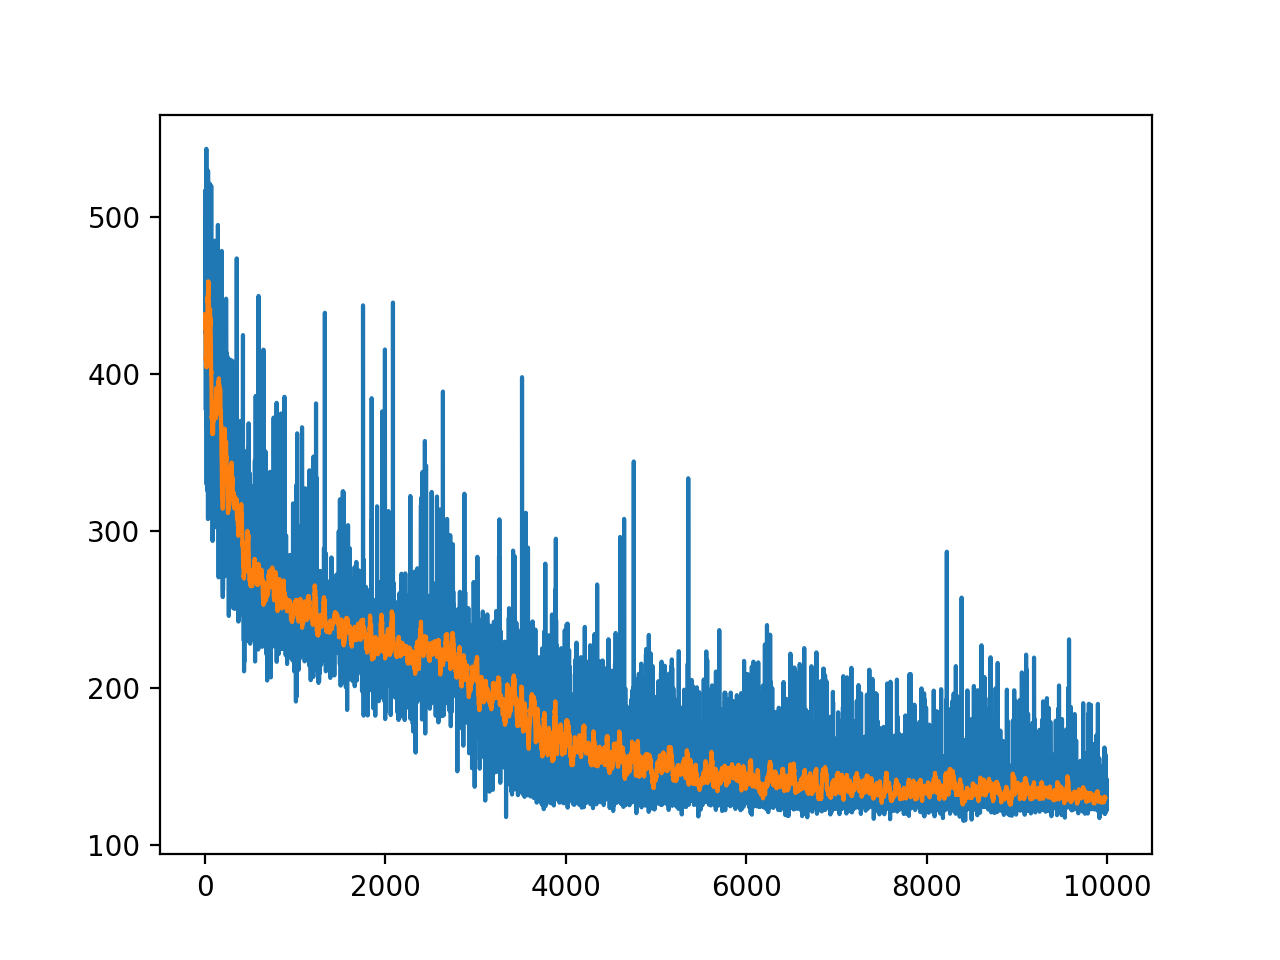

<IPython.core.display.Javascript object>


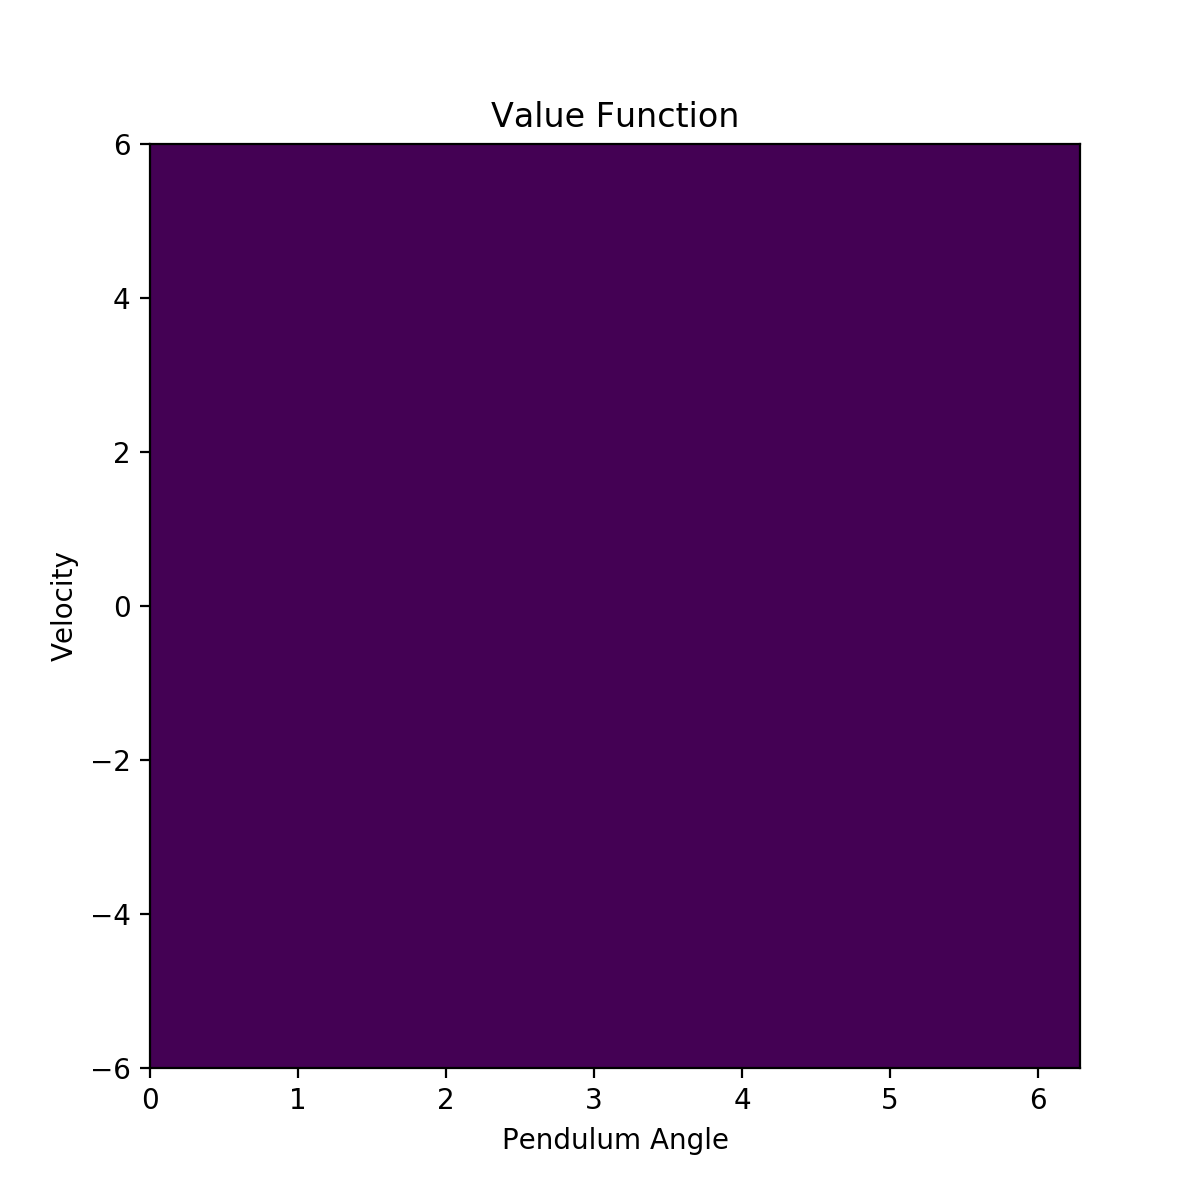

<IPython.core.display.Javascript object>


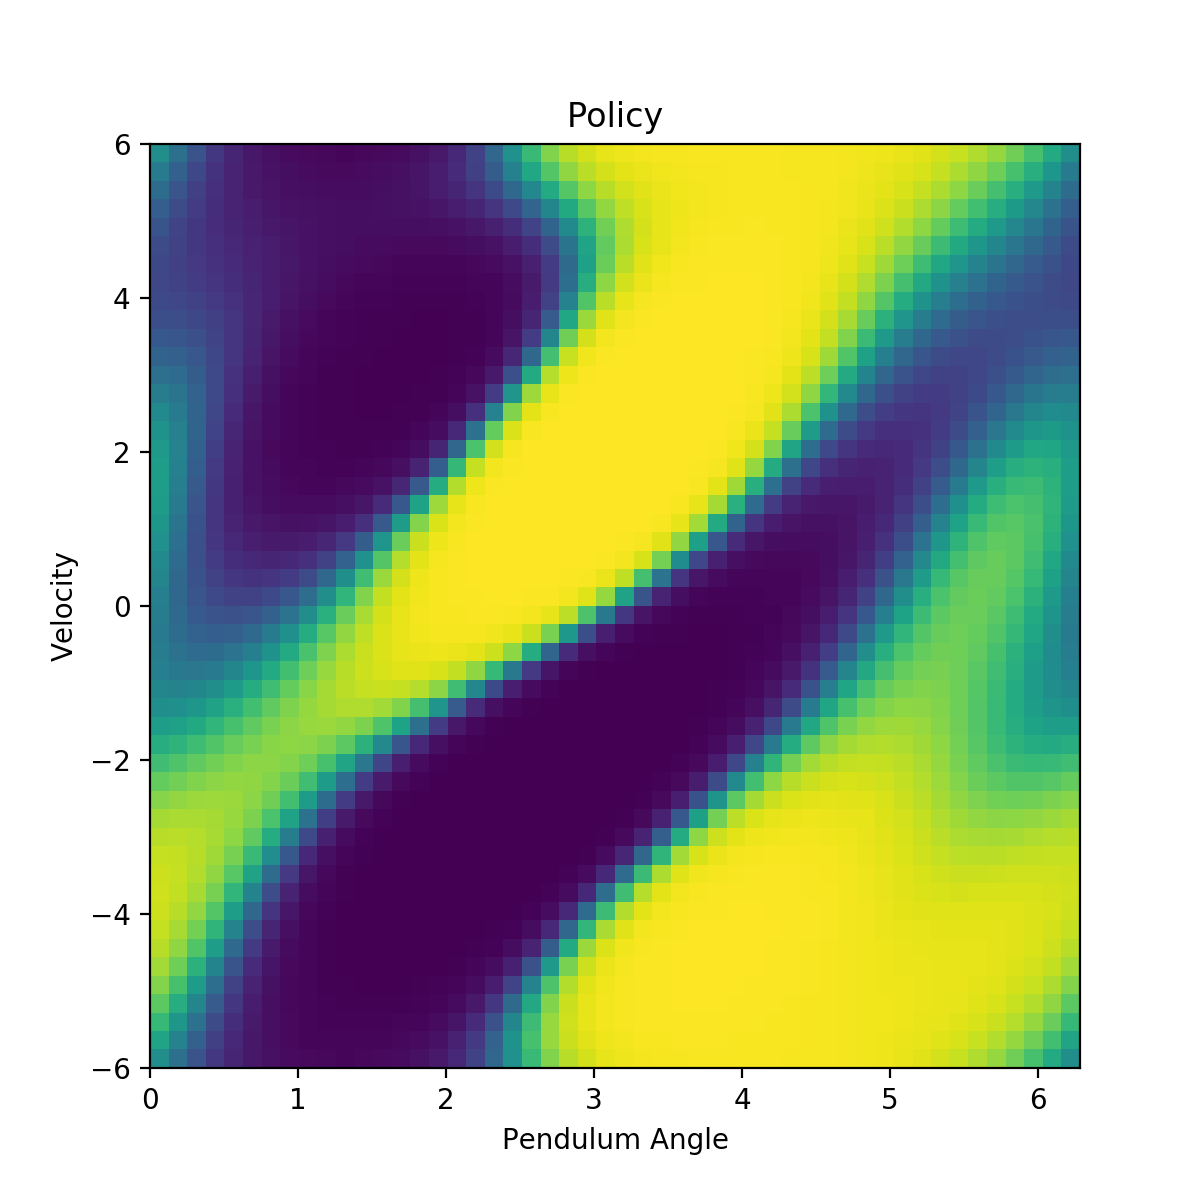

<IPython.core.display.Javascript object>


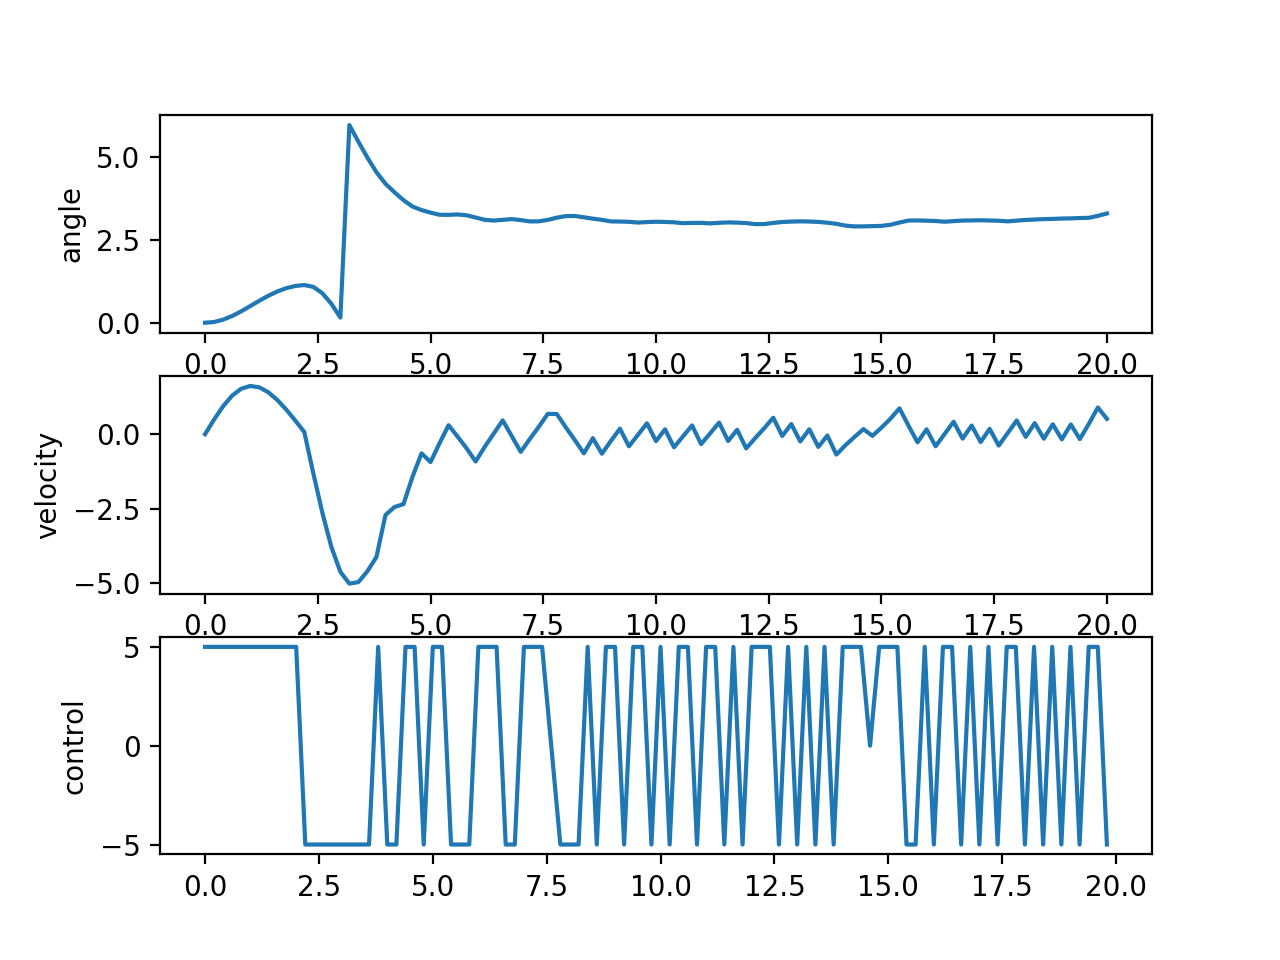

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAB7F21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAM6WWI
hAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIGZJnp
cUkTgA8wx7J03TT8KodCGFz3ILMf1XToD7aSZN8Zs9uaEA9jcSCQE44zxR7Qj2Eksq8+z+WqZvqh
qAmjtIUGvU4G5QJBAUbbGyaCYw38oY0EiqMUzXsdmysQKkUzaDNvexFsZpfdheEoKgGvZW8G2fPt
zPJdE33RzWsoHAbqHv7LUb1Fy2Yp1iQ19n08hwvr7IO0kg4fVQgC6P3/C57Zm0TDpNKoFwovx46y
wGgxxfs9fMlSyts++IhsON1YTXSZ+7DpOh9xNtWwLsYWvRnBU9gf4A7JwBQWOYAYmT3lcVdHEKo8
nPrWs29KQIrElzYOcOrbfLWcYFnRbvHGqlT+KBEQp3z6oWoiYMnqr8QIiolEN4vX5b2C+zQHzQ2f
vvWqjUvqvwklaEjJ+ye8BI4h+X6tXM23SjarA7G2VWJeukUYV1f6En/4Djaes3NIi9ChsJvVZhX7
Rpm2Il8+frDU+8bix21f4FPyGkoTH6Uajh/DuATU5DNYJFJ/9Q2Np2xlEu8a69hQoJ3BMSRZ+ik+
prV10KxzWeUg9fl/KzQf3QipvP+pg7wAFlohaNC+X9u9nLEzN5JalqkEgZ+C32PFL8apw+fmrMvk
Ku3kze1cjvQ9eb1WVr8dVoLGA8gIj3RsKwjJVzi7c90t+ieO9MCw0lXGYRNCiQaDZiZVI5+v1x/u
fiDNE3nD/IanQLy6t9o83DsYu24MqBTsK+wiiVs0w3Runi41ACtxi3e1ZRSpvSro6MFg5teO5iPF
QZkAEosscU3/q96JNfAK/NlB7NX+DkdEtXVicWp15YYNuQJZ9mZvVsR7ijRkLzGOkSvXbQmbL/4K
lU38sIFvjeZTDthPv8rmdtQWMTZ9ZsfNGQ0+4WiIhQCKEe2apzkYyHwpmbJ23XWrIyGQYucUVeu2
GjYKVYlZ560+DWGFqnAjgeRjj+Wp3s91P3xZicf/t/LgxWFjxddQZPBSE1eyTy2OI+p6W1cAPIlE
UVq+e1mS+77NpyuHU32QjaVBIoJEpLNu+jJg0cavZPThPqDyEF+cOBlFa+wk7otCuLjhySyOf2d3
EioEvrlbyetESfz08/8KWb/dLGfmQiUOP/++It/W/8NbSO1IJQbqaSovYADMjkL5pMqav0SItqnm
ExnqfETtwL8PCLGodx46AroVMHL1XC83I2BN484eE12l1sJIfKG2C937ntYVsNmsaJyB/ahMFcTu
xmzdefbwmjMPl1k7d2uTV8FsvilaQqhqfo2uV/mrL8nCbXTLuxquCHP1uETte4U8gBh+1DYowFZO
CzG0ZBBzGP/TMgHFui/a6LUi/Yv91128C64Q10r/Nz3qEXT6mZU3mC4yi3dkIQ+OP1yMjZhvvL3G
2SzzAwKPcgQ8dtoWcUUdwf9jA1JoevxZ0ObW0ILYjT292Aco44S8N9+XB1UFseMFcg60zXFjJbsP
TelzlRAJin/uin531Shn92/VtjkFNU3SMiAAA3xVnN0mkJt+04NgNFW4chV2/M7qkxTZQE6SztRR
6NhdkrSo6wpqksAc3C1gXCczUNIsrTg04T/1X3RBihUS4TBYNAHjBNxOSyZO1txOLvyBPw23gM/C
RqIRHn+zrdS1n9sagKIansF4dE3Smi/kBQqWPJbeTelk2hma4g9A9QLb9Nhz1Bd0RaX+yo81Ji0+
Pomap78opr8yfJ6zWndC78FJocItI8ZtxtDRRBQwLBlAunmtPk+4mpoBd1K6cNH0nnMLq8bsKFYY
DcIhwVZHD55IVVgpqAXNZeSI2adRSP/kS3L+bgTPqaHtDTorEo1sGhDsAqFzLsB57qkTrDi2wqzo
5rRbTEXgOAdY5bjJQGOae9FSFXiF3uMs0Ub8xBcbFHGqSJfhcWh9RDH2F/paAYa29it9Kxv3wCSO
fJ6Nz1o//QfDyos2PI7hWsec2lZdy362N10kKhlJqGvYnBllfhcxLnqWgs99zmr52uxX9tFub9GP
KvNvsGNmbrN91sU7gWmbZR0yPRDsRKFMk709bCH+faSFBG3t6GkL8z1VhmAHNb2GjNASDf59t+Eb
/ArN5FC6MIZ4J7ozZ33nG04ofIf0xuHDRxOBLY64IMK7BLy3HZP0OY7XRb2D9cSCYVW1M7PMYJCV
oQ94xv/wcKVUAspD89QzuOrOs3wpoU500xrMddWWjpM68NFV4CcFJyguOu0o2w+jKiK+PqfxFkdD
ZuBH3q6Yd5yqpRHD+fqEM4xlNc1qdCZJp2ARL8xAjG6/art8e1k6J5t5hWetUNrC63b0pE0dIjqX
vg1c09fXT+mNxjaUKhyYCVHOPQxEMAADouges2fSANuAkEABdgAAKXoABVMNc9AAO039M70f6yL2
JflHEYi16BWPlbDgsoMZjaWFnvJj1PG38O1gjhOM5pQ9FGtxPVPpXJ54onfH5J+5vVgR4TxErbYo
6vCFcdQSY1WuO/8KuEH3alnuU4Dote3ncb+Jke2xvDAQIk9ZggNtCFPJoRWNB8l2jYVSLnMGSDO2
mCsXsZVRqtj5eetpCsl8BPC1mWgc7tB24Cwhn8lO7TzQau6yGCZ7pVwdPRXILRHkU/u5X2opuffq
H8YjdaijM+al/1FNN4tDJ5UHM/y29/F2L3VTojn/VO1u0A8Xw6CqZL6dseNwE/jP/pZW/OIaXqvT
x8j/gnXPLQOncMJRJe7b5DtUYA9POyUCbDbJnknqchmNZyz//Xg1zFM/x3eZXR7/wLOG3DkkN47W
hHFXxm0ns1PcxJ9PmAsAQoxv9li2z8D9FsvbhxfkKIylvZZWihvC/Toq68lVB5KfWnhLi9vgv7Ra
MplMFqjSQ1fZNebaSE4/q

In [25]:
# here we learn doing 300 episodes
lear = reinforce.iterate(10000) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear)
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum1, val, pol, control_policy, animate=True)

d)Reinforce algorithm with baseline

we generate 10000 episodes to guarantee the convergence and as we can see from the learning curve, it roughly take 6000 episodes to converge and as shown in the animation, the obtained policy successfully balanced the pendulum. 

e)Reinforce with baseline outperforms pure reinforce, because it takes less episodes to converge, though this may not be very convincing, as the difference in the number of episodes is not obvious. However, on the other hand, we think that by subtracting a baseline from $G_t$, reinforce alogrithm produces the gradient esitmation with lower variance, which imporves the performance of the gradient update.


In [10]:
# reinforce with baseline 
# we re-initilize policy and value 
pendulum2 = Pendulum()
policy_baseline = StochasticPolicyPeriodicFeatures(controls = pendulum2.controls, order = 2)
value_baseline = ValueFunctionPeriodicFeatures(order = 2 )
reinforce_baseline = Reinforce(pendulum2, cost, policy_baseline, value_baseline,
                               policy_learning_rate = 1e-7, value_learning_rate=1e-1)


<IPython.core.display.Javascript object>


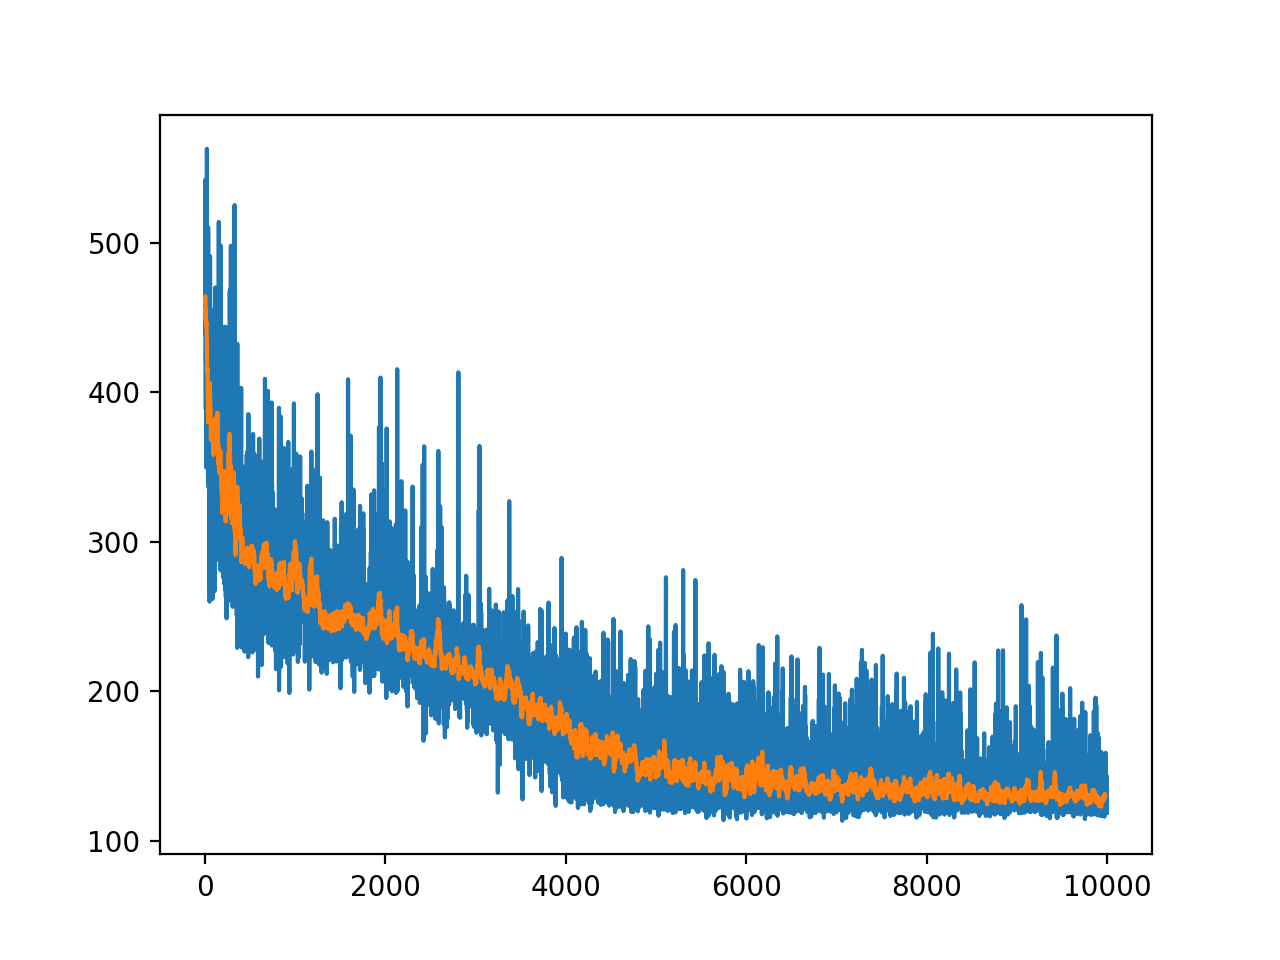

<IPython.core.display.Javascript object>


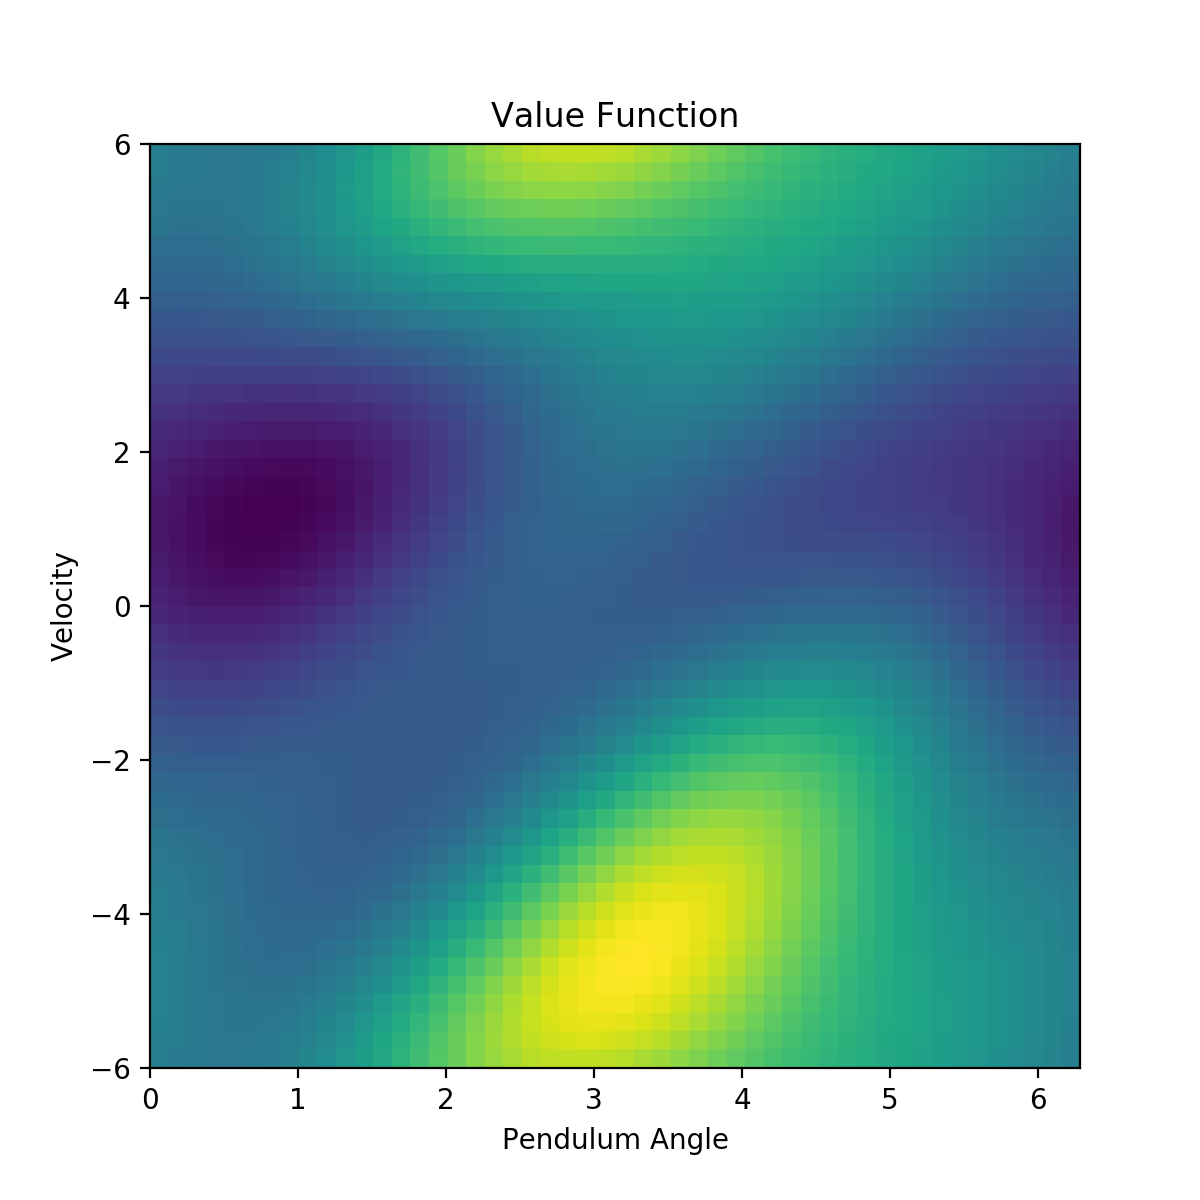

<IPython.core.display.Javascript object>


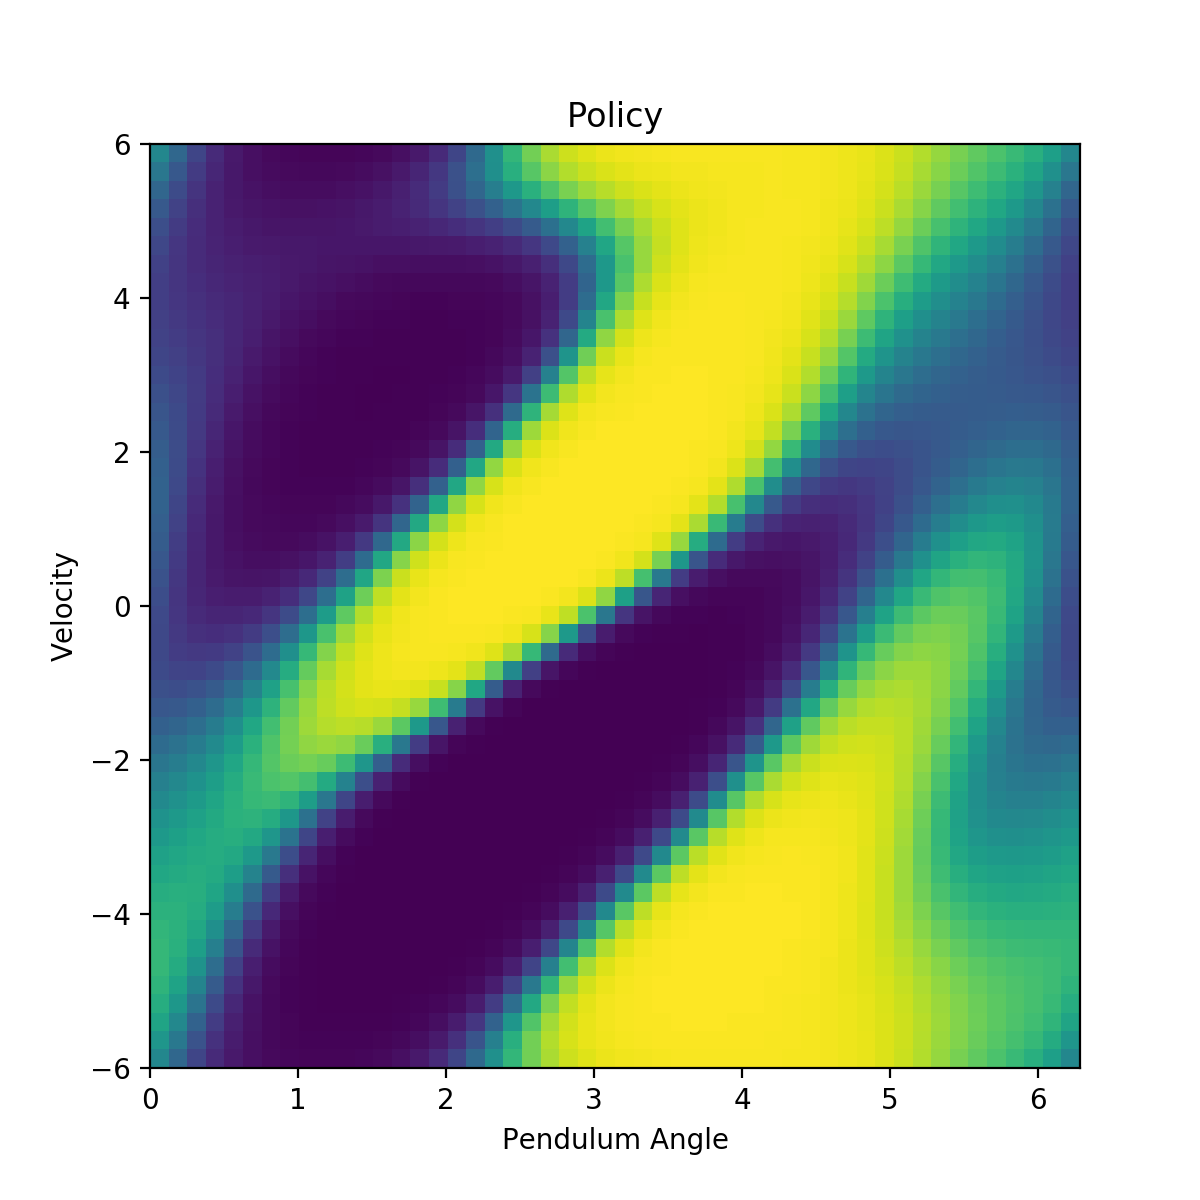

<IPython.core.display.Javascript object>


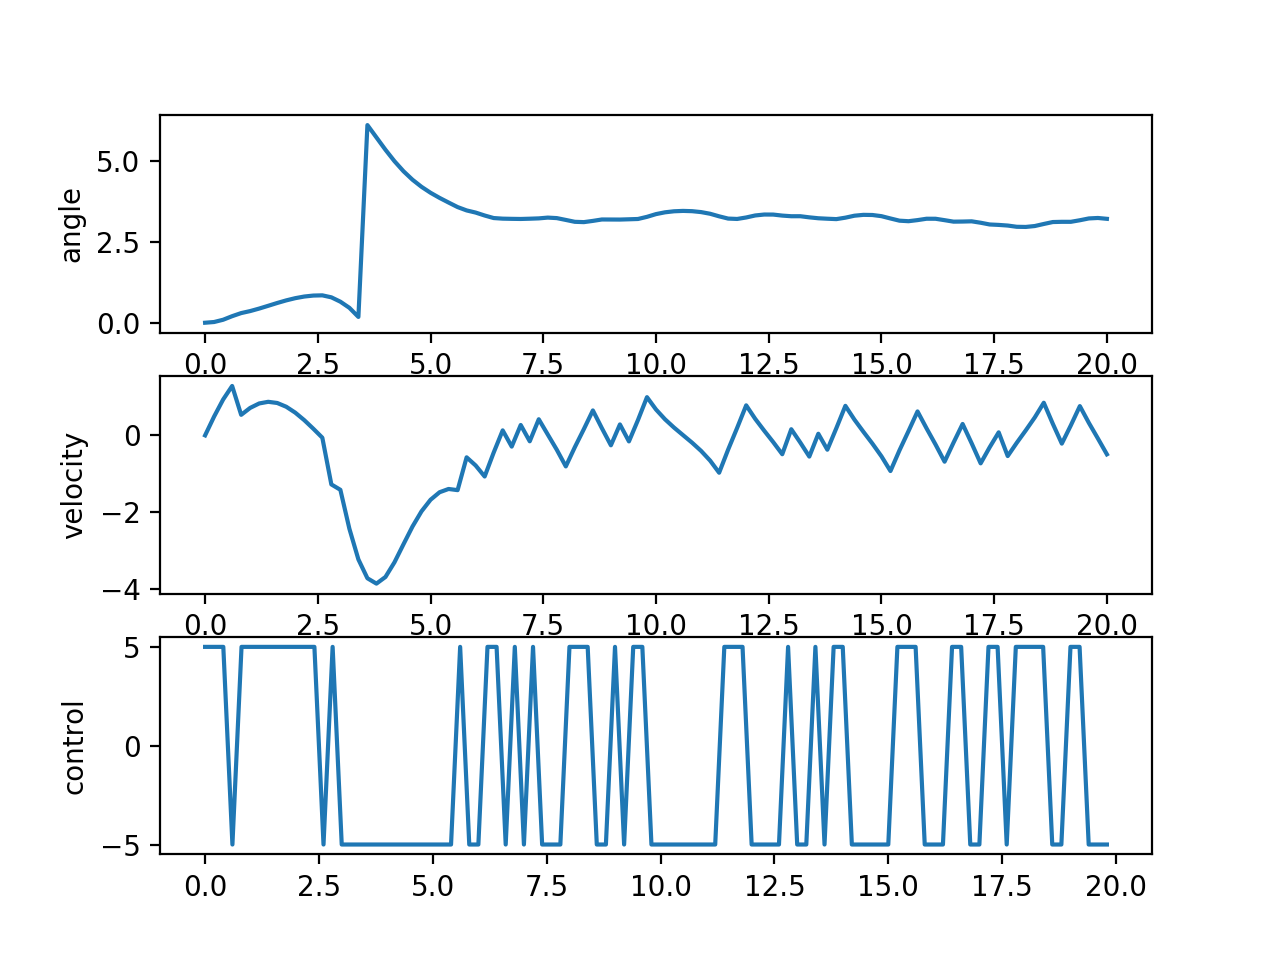

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACIjG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTIgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAM9WWI
hAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIGZJnp
cUkTgA8wx7J03TT8KodCGFz3ILMf1XToD7aSZN8Zs9uaEA9jcSCQE44zxR7Qj2Eksq8+z+WqZvqh
qAmjtIUGvU4G5QJBAUbbGyaCYw38oY0EiqMUzXsdmysQKkUzaDNvexFsZpfdheEoKgGvZW8G2fPt
zPJdE33RzWsoHAbqHv7LUb1Fy2Yp1iQ19n08hwvr7IO0kg4fVQgC6P3/C57Zm0TDpNKoFwovx46y
wGgxxfs9fMlSyts++IhsON1YTXSZ+7DpOh9xNtWwLsYWvRnBU9gf4A7JwBQWOYAYmT3lcVdHEKo8
nPrWs29KQIrElzYOcOrbfLWcYFnRbvHGqlT+KBEQp3z6oWoiYMnqr8QIiolEN4vX5b2C+zQHzQ2f
vvWqjUvqvwklaEjJ+ye8BI4h+X6tXM23SjarA7G2VWJeukUYV1f6En/4Djaes3NIi9ChsJvVZhX7
Rpm2Il8+frDU+8bix21f4FPyGkoTH6Uajh/DuATU5DNYJFJ/9Q2Np2xlEu8a69hQoJ3BMSRZ+ik+
prV10KxzWeUg9fl/KzQf3QipvP+pg7wAFlohaNC+X9u9nLEzN5JalqkEgZ+C32PFL8apw+fmrMvk
Ku3kze1cjvQ9eb1WVr8dVoLGA8gIj3RsKwjJVzi7c90t+ieO9MCw0lXGYRNCiQaDZiZVI5+v1x/u
fiDNE3nD/IanQLy6t9o83DsYu24MqBTsK+wiiVs0w3Runi41ACtxi3e1ZRSpvSro6MFg5teO5iPF
QZkAEosscU3/q96JNfAK/NlB7NX+DkdEtXVicWp15YYNuQJZ9mZvVsR7ijRkLzGOkSvXbQmbL/4K
lU38sIFvjeZTDthPv8rmdtQWMTZ9ZsfNGQ0+4WiIhQCKEe2apzkYyHwpmbJ23XWrIyGQYucUVeu2
GjYKVYlZ560+DWGFqnAjgeRjj+Wp3s91P3xZicf/t/LgxWFjxddQZPBSE1eyTy2OI+p6W1cAPIlE
UVq+e1mS+77NpyuHU32QjaVBIoJEpLNu+jJg0caTX4ReH5eeZU5A8C7fKodLWruDM0AUhd2ISQ1Q
WEZn+/eICyBrRE749PQuixm/3Sxn5kIlEvH/rJN7r7FuVH7mq2PHljU4/gADd/hNaB09O4CKkZd7
DKYT44yODSHixBVPUO48kMNJGpeauxdoCjS2rxPtg4882WW8kPlDbBe79z2sK2GzWNJQmdvNYOqW
L48TFoBATzjjXqd7MsLlkxbwjK9MoThyrJohoIu13F+ThNrpl3Y+nYv9a3CJ2vcKeU7CjahsUYCs
nBZjaMpYNdj/0zIBxbov2rBX80qqREYAijLEcGXw/4jmnBe2QTw4ewM6dqo4+l2e7lK3ttGL2L+4
2yWeg+WuTyD4yehsRkZRSNif2MDmTVk1QehR1r4MLTRkeepLAyGRqShDdLnD7K/eJ3JndVZPKgtc
UijZjFmavXD9awph4L3X2857coerRkgKqe/3advRqIpYh+xTTgAD/RnBdRXFhfgiWGH9iYKTAtzG
rREswKbUEyWdqKPRsLsldeyIcX38m6eLf/A2vN1LM9VUtCawdxilnWlDDAZTiqdu9xn+2XXbP/J1
c+ID+QJ+G4APQpRmATCeDUAQbhEUpo3pb1Z0AyPwu+u4/63qWrW1qJvg4e9yZjI+NPFM/UsCtpPL
TdBulxfW8Ax2OS3+r3IoAyoG/bCVaXQMk7h/Zbp3jzUhkOCEShOFkElRJl/VThMBmwdZYcslD8gV
pc5GYZoSJx5pGx5vRYcavPcr5uvo/dt6Rf92uzSP3x1P/lU3L+bzPIowKOTxPyhuzfQS5dAyh7CW
3+B76+ezbgLa4PXtR7mlIE7N/I6/73yuKmjdxGQkk+QjMGLYVc+f/n96Ysls9EnW63NO/oJzRbwr
sojb3lz2XTT0bngmC5/w4GsEYcwJ51H/C+Ths/BBMF7WT8Bx0mnI0KF3B4SpwhCgSufyZ8Wp7RWt
HaLZKZh6R2zd5XpxMcJkLiQ9or/9cYxJl+TtvdFEsZFMFcL3ra3V1+qMWklvx/0apM0tza09WIdF
WvL+lcPS7n7kH/4f/vuuMkb0jUNbvXtUXDCVzv90zcSfrN4DD+u6DaofmJehitZqZuCdPjz7vqLk
J38JPDJJsVZKXBcVbANgWfx//Jh65qXqd4PUdXUGtq7N08N6NLtZ1SO2kzrwzwqRYgFyp034RYWq
b5sGm8zE7O10AJyspJsIVRTO0uor2Gbu60boPQzUpgOQIhTsDPCQZ6NZy8qmait/uquzgQ+3Slfd
ujvngg5tnL6AtAwHp6+un9Mbu9PlKN5D1UPIF7AAAZbiPWuavAq7HapZUEGswACBAAADAIbaAA7w
WFFi8Vl+uaSkDaIcW1dFUDi9trI3A33qlzfQ5QIFDQIx6ybtzb/RKqenGc0oeijW4n63eGkgbP1C
bQ94/SqqikpuA23lH6jzQvcxlYEAHqj8NAc+wtwg+7Us9sR4BM0TNyiNfeeOx/F8ZbsheFsTJ2hw
AIGJqNd6JbmYjkI4jJO/dAJL4ZrznDVbHy1p9tq3GACeFrMtA53aDtwFgkHCFCA2kKqBSajAqjoI
ydPRXILRb3LwpI/lvVonfqH8YjdaijNBC24PVHCFMRNI3wEsurKKPVnEjo4V/9U7YYLumfYnChz2
vNuvL13n1H/byPN2pycgvT0hoby3P7RG26ej3XPESB+IE7pBAITxflWjw8NZMs1nNjf+yXSajZ2v
BXTNzU2Zc2Yb9lhPpA5sksHl9c65gJhBs3GBs0yMdvJW5iuCZ83RdzbHIfbLiSWWVoobwv06KuvJ
VQb+GjTLGl/rjbpRgmwzV

In [11]:

lear_v = reinforce_baseline.iterate(10000, baseline=True) 

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear_v)
ret_v = np.cumsum(lear_v)
win_avg = 20
ret_v[win_avg:] = ret_v[win_avg:] - ret_v[:-win_avg]
plt.plot(ret_v[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce_baseline.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce_baseline.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum2, val, pol, control_policy, animate=True)

